             欠損数          %
PassengerId    0   0.000000
Survived       0   0.000000
Pclass         0   0.000000
Name           0   0.000000
Sex            0   0.000000
Age          177  19.865320
SibSp          0   0.000000
Parch          0   0.000000
Ticket         0   0.000000
Fare           0   0.000000
Cabin        687  77.104377
Embarked       2   0.224467
             欠損数          %
PassengerId    0   0.000000
Pclass         0   0.000000
Name           0   0.000000
Sex            0   0.000000
Age           86  20.574163
SibSp          0   0.000000
Parch          0   0.000000
Ticket         0   0.000000
Fare           1   0.239234
Cabin        327  78.229665
Embarked       0   0.000000
{'penalty': 'l1', 'fit_intercept': True, 'C': 0.1, 'random_state': 0}
training score :  0.7934904601571269
[0 1 0 0 1 0 1 0 1 0 0 0 1 0 1 1 0 0 1 1 0 0 1 0 1 0 1 0 0 0 0 0 1 1 0 0 1
 1 0 0 0 0 0 1 1 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 0 1 1 0 1 0
 1 1 0 1 0 1 0 1 0 0 0 0 1 1 1 0 1 0 1 0 0 

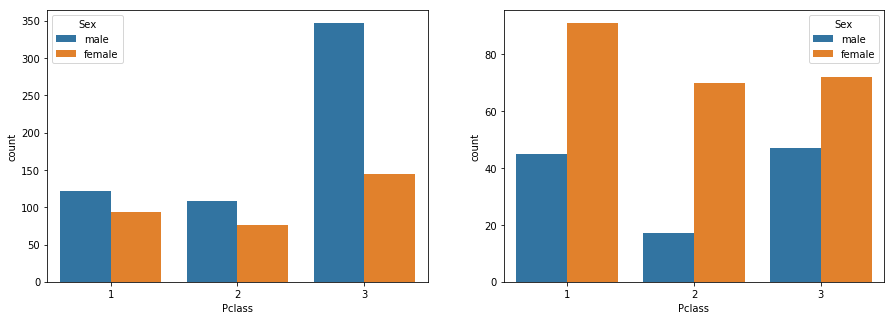

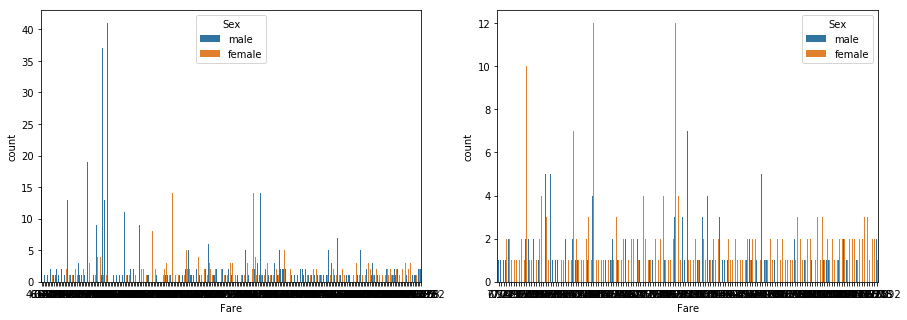

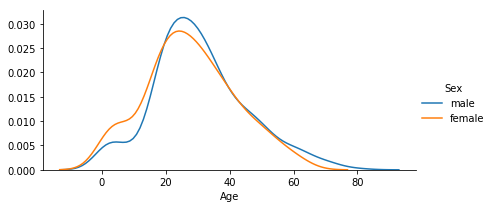

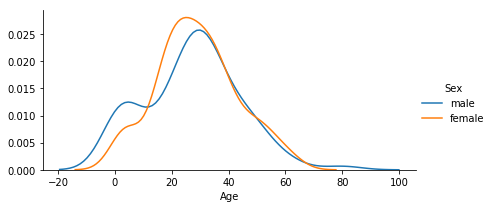

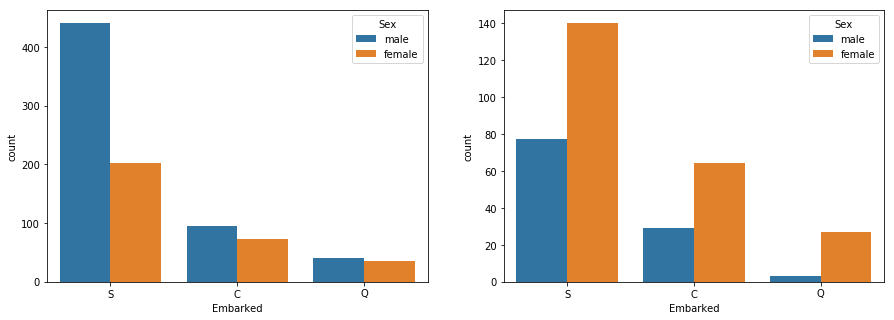

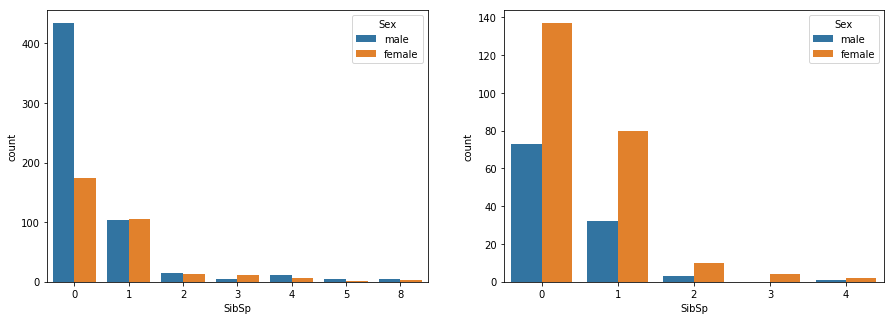

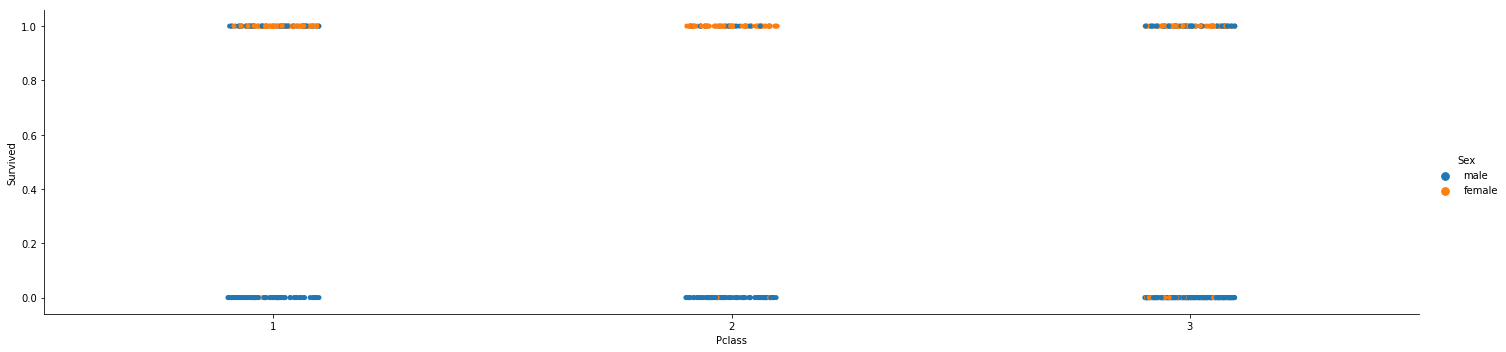

In [2]:
#ロジスティック回帰分析　sklearn
# -*- coding: utf-8 -*-
%matplotlib inline
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import os

import pickle
from google.cloud import storage

from sklearn.model_selection import StratifiedKFold,ParameterGrid
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss,roc_auc_score
from sklearn.externals import joblib

#一時的にwarnings非表示に・・
import warnings
warnings.filterwarnings('ignore')

PROJECT_ID = 'verdant-wares-237302'
CLOUD_STORAGE_BUCKET = 'verdant-wares-237302.appspot.com'


#GCSからCSV読み込み
train = pd.read_csv("gs://sample_machine_learning_input/train.csv", sep=",")
test = pd.read_csv("gs://sample_machine_learning_input/test.csv", sep=",")

#欠損データの確認用関数
def missingData_table(df): 
        null_val = df.isnull().sum()
        percent = 100 * df.isnull().sum()/len(df)
        kesson_table = pd.concat([null_val, percent], axis=1)
        kesson_table_ren_columns = kesson_table.rename(
        columns = {0 : '欠損数', 1 : '%'})
        return kesson_table_ren_columns

#欠損数・率を算出
print(missingData_table(train))
print(missingData_table(test))


# [START upload_file]
def upload_file(file_stream, filename, content_type):
    storage_client= storage.Client(project=PROJECT_ID)
    bucket = storage_client.bucket(CLOUD_STORAGE_BUCKET)
    blob = bucket.blob(filename)

    blob.upload_from_string(
        file_stream,
        content_type=content_type)

    url = 'gs://{}/{}'.format(CLOUD_STORAGE_BUCKET, filename)

    return url
# [END upload_file]



#--客室等級毎の男女数
fig,ax = plt.subplots(1,2,figsize=(15,5))
train_view1 = train[(train['Survived']>0)]

#Pclass毎の男女比
sns.countplot('Pclass',data=train,hue='Sex',ax=ax[0],hue_order=['male','female'])
sns.countplot('Pclass',data=train_view1,hue='Sex',ax=ax[1],hue_order=['male','female'])


#--運賃毎の男女比
fig,ax = plt.subplots(1,2,figsize=(15,5))
sns.countplot('Fare',data=train,hue='Sex',ax=ax[0],hue_order=['male','female'])
sns.countplot('Fare',data=train_view1,hue='Sex',ax=ax[1],hue_order=['male','female'])

#男女比の密度分布
fig = sns.FacetGrid(train,hue='Sex',aspect=2,hue_order=['male','female'])
fig.map(sns.kdeplot,'Age')
fig.add_legend()

fig = sns.FacetGrid(train_view1,hue='Sex',aspect=2,hue_order=['male','female'])
fig.map(sns.kdeplot,'Age')
fig.add_legend()

#--運賃毎の男女比
fig,ax = plt.subplots(1,2,figsize=(15,5))
sns.countplot('Embarked',data=train,hue='Sex',order=['S', 'C', 'Q'],ax=ax[0],hue_order=['male','female'])
sns.countplot('Embarked',data=train_view1,hue='Sex',order=['S', 'C', 'Q'],ax=ax[1],hue_order=['male','female'])

#--
fig,ax = plt.subplots(1,2,figsize=(15,5))
sns.countplot('SibSp',data=train,hue='Sex',ax=ax[0],hue_order=['male','female'])
sns.countplot('SibSp',data=train_view1,hue='Sex',ax=ax[1],hue_order=['male','female'])

#--
fig,ax = plt.subplots(1,2,figsize=(15,5))
sns.countplot('Parch',data=train,hue='Sex',ax=ax[0],hue_order=['male','female'])
sns.countplot('Parch',data=train_view1,hue='Sex',ax=ax[1],hue_order=['male','female'])


#生存、死亡分布（年齢、運賃）
sns.lmplot(x='Age',y='Fare',data=train,fit_reg=False,hue='Survived')

#Pclass毎性別での生存
sns.catplot('Pclass','Survived',hue='Sex',data=train,aspect=4,hue_order=['male','female'])

#データ整形
train_ch = train.drop(['Name','Ticket','Cabin'],axis=1)
test_ch = test.drop(['Name','Ticket','Cabin'],axis=1)

#参照のコピーなので参照先が変更された場合にコピー先も変更される為ワーニングが出ている
#assignは内部でcopyを使ってディープコピーを作る
#df_2 = df[df['B'] == 1]
#df_2 = df_2.assign(C=100)
#いったんサンプルのためワーニングは無視
#tranData
train_ch["Age"] =train_ch["Age"].fillna(train_ch["Age"].median())
train_ch["Embarked"] = train_ch["Embarked"].fillna("S")

train_ch["Sex"][train_ch["Sex"] == "male"] = 0
train_ch["Sex"][train_ch["Sex"] == "female"] = 1

train_ch["Embarked"][train_ch["Embarked"] == "S" ] = 0
train_ch["Embarked"][train_ch["Embarked"] == "C" ] = 1
train_ch["Embarked"][train_ch["Embarked"] == "Q"] = 2

#testData
test_ch["Age"] = test_ch["Age"].fillna(test_ch["Age"].median())
test_ch["Fare"] = test_ch["Fare"].fillna(test_ch["Fare"].median())
test_ch["Embarked"] = test_ch["Embarked"].fillna("S")

test_ch["Sex"][test_ch["Sex"] == "male"] = 0
test_ch["Sex"][test_ch["Sex"] == "female"] = 1

test_ch["Embarked"][test_ch["Embarked"] == "S" ] = 0
test_ch["Embarked"][test_ch["Embarked"] == "C" ] = 1
test_ch["Embarked"][test_ch["Embarked"] == "Q"] = 2

#ためしにカラム削ってみる
train_ch = train_ch.drop(['Embarked','Age'],axis=1)
test_ch = test_ch.drop(['Embarked','Age'],axis=1)


#整形したテストデータの出力
train_ch.to_csv('gs://sample_aip_job/input/change.csv',index=False)

#モデル作成
X_train = train_ch.drop('Survived', axis=1)
y_train = train_ch.Survived


#cross
cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=0)

#ParameterGrid
all_params = {'C':[10**i for i in range(-3,4)],
              'fit_intercept':[True,False],
              'penalty':['l2','l1'],
              'random_state':[0]
             }

min_score = 100
min_params = None

#パラメータ探し ParameterGrid
for params in ParameterGrid(all_params):

    #クロスバリデーション
    list_logloss_score = []
    list_auc_score = []
    for train_idx,valid_idx in cv.split(X_train,y_train):

        trn_x = X_train.iloc[train_idx, :]
        val_x = X_train.iloc[valid_idx, :]
        trn_y = y_train[train_idx]
        val_y = y_train[valid_idx]

        log_reg = LogisticRegression(**params)
        log_reg.fit(trn_x, trn_y)

        pred = log_reg.predict_proba(val_x)[:,1]
        sc_logloss = log_loss(val_y,pred)
        sc_auc = - roc_auc_score(val_y,pred)
        
        list_logloss_score.append(sc_logloss)
        list_auc_score.append(sc_auc)
        #print(list_logloss_score)
        #print(list_auc_score)
        
    sc_logloss = np.mean(list_logloss_score)
    sc_auc = np.mean(list_auc_score)
    
    if min_score > sc_auc:
        min_score = sc_auc
        min_params = params
        
print(min_params)


weight_param = {'sex':2
             }
min_params['class_weight'] = []

log_reg = LogisticRegression(**min_params)
log_reg.fit(X_train, y_train)


#joblib.dump(log_reg, './cars.pkl')

#学習済みモデルをGCSへ保存
model = pickle.dumps(log_reg)
url = upload_file(model, 'RandomForestModel.pkl', 'application/octet-stream')




#df = joblib.load('./cars.pkl')
#pd.to_pickle(df,'gs://kaggule_sampletest/output/model.pkl')

#モデル評価
print("training score : ", log_reg.score(X_train, y_train))

survived_predict = log_reg.predict(test_ch)

print(survived_predict)

df_f = pd.DataFrame(survived_predict)



submittion_file = pd.concat([test_ch.PassengerId,df_f ], axis=1)
submittion_file.columns = ['PassengerId', 'Survived']
print(submittion_file.head())
submittion_file.to_csv('gs://sample_machine_learning_output/out3.csv', index=False)

